Cloning into 'course-v3'...
remote: Enumerating objects: 4, done.
remote: Counting objects: 100% (4/4), done.
remote: Compressing objects: 100% (4/4), done.
remote: Total 4048 (delta 0), reused 0 (delta 0), pack-reused 4044
Receiving objects: 100% (4048/4048), 203.00 MiB | 25.55 MiB/s, done.
Resolving deltas: 100% (2264/2264), done.


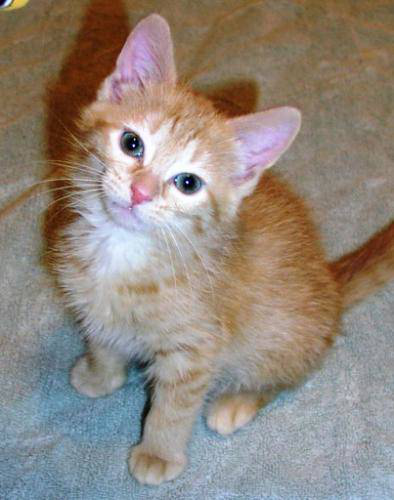

In [1]:
!git clone https://github.com/fastai/course-v3
from pathlib import Path
from PIL import Image

data_folder = Path("course-v3/nbs/dl1/images/notebook_tutorial/")

file_to_open = data_folder / "cat_example.jpg"

Image.open(file_to_open)

In [0]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline


In [0]:
from fastai.vision import *
from fastai.callbacks.hooks import *
from fastai.utils.mem import *

In [4]:
path = untar_data(URLs.CAMVID)
path.ls()

[PosixPath('/root/.fastai/data/camvid/valid.txt'),
 PosixPath('/root/.fastai/data/camvid/codes.txt'),
 PosixPath('/root/.fastai/data/camvid/images'),
 PosixPath('/root/.fastai/data/camvid/labels')]

In [0]:
path_lbl = path/'labels'
path_img = path/'images'

In [6]:
fnames = get_image_files(path_img)
fnames[:3]


[PosixPath('/root/.fastai/data/camvid/images/0016E5_06300.png'),
 PosixPath('/root/.fastai/data/camvid/images/0006R0_f01680.png'),
 PosixPath('/root/.fastai/data/camvid/images/Seq05VD_f02550.png')]

In [7]:
lbl_names = get_image_files(path_lbl)
lbl_names[:3]

[PosixPath('/root/.fastai/data/camvid/labels/0016E5_07530_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/Seq05VD_f00510_P.png'),
 PosixPath('/root/.fastai/data/camvid/labels/0016E5_06870_P.png')]

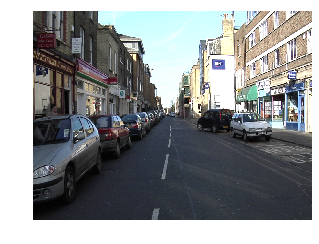

In [8]:
img_f = fnames[0]
img = open_image(img_f)
img.show(figsize=(5,5))

In [0]:
get_y_fn = lambda x: path_lbl/f'{x.stem}_P{x.suffix}'

In [20]:
print(get_y_fn)

<function <lambda> at 0x7f98affdd6a8>


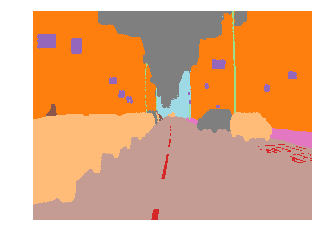

In [10]:
mask = open_mask(get_y_fn(img_f))
mask.show(figsize=(5,5), alpha=1)

In [11]:
src_size = np.array(mask.shape[1:])
src_size,mask.data

(array([720, 960]), tensor([[[ 4,  4,  4,  ...,  4,  4,  4],
          [ 4,  4,  4,  ...,  4,  4,  4],
          [ 4,  4,  4,  ...,  4,  4,  4],
          ...,
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17],
          [17, 17, 17,  ..., 17, 17, 17]]]))

In [12]:
codes = np.loadtxt(path/'codes.txt', dtype=str); codes

array(['Animal', 'Archway', 'Bicyclist', 'Bridge', 'Building', 'Car', 'CartLuggagePram', 'Child', 'Column_Pole',
       'Fence', 'LaneMkgsDriv', 'LaneMkgsNonDriv', 'Misc_Text', 'MotorcycleScooter', 'OtherMoving', 'ParkingBlock',
       'Pedestrian', 'Road', 'RoadShoulder', 'Sidewalk', 'SignSymbol', 'Sky', 'SUVPickupTruck', 'TrafficCone',
       'TrafficLight', 'Train', 'Tree', 'Truck_Bus', 'Tunnel', 'VegetationMisc', 'Void', 'Wall'], dtype='<U17')

In [13]:
size = src_size//2

free = gpu_mem_get_free_no_cache()
# the max size of bs depends on the available GPU RAM
if free > 8200: bs=8
else:           bs=4
print(f"using bs={bs}, have {free}MB of GPU RAM free")

using bs=8, have 11430MB of GPU RAM free


In [0]:
src = (SegmentationItemList.from_folder(path_img)
       .split_by_fname_file('../valid.txt')
       .label_from_func(get_y_fn, classes=codes))

In [0]:
data = (src.transform(get_transforms(), size=size, tfm_y=True)
        .databunch(bs=bs)
        .normalize(imagenet_stats))

In [16]:
5+5

10

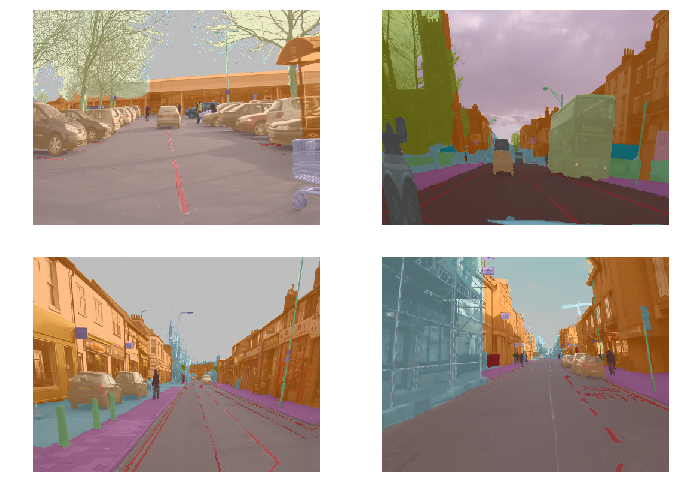

In [17]:
data.show_batch(2, figsize=(10,7))

In [0]:
name2id = {v:k for k,v in enumerate(codes)}
void_code = name2id['Void']

def acc_camvid(input, target):
    target = target.squeeze(1)
    mask = target != void_code
    return (input.argmax(dim=1)[mask]==target[mask]).float().mean()

In [0]:
metrics=acc_camvid

In [0]:
learn = unet_learner(data, models.resnet34, metrics=metrics, wd=1e-2)

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


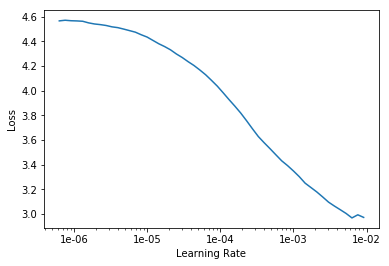

In [31]:
lr_find(learn)
learn.recorder.plot()

In [0]:
lr=3e-3

In [0]:
fit_one_cycle??

In [34]:
learn.fit_one_cycle(10, slice(lr), pct_start=0.9)

epoch,train_loss,valid_loss,acc_camvid,time
0,1.253760,0.870585,0.797231,03:52
1,0.858418,0.588427,0.838059,03:43
2,0.696339,0.686527,0.825014,03:42
3,0.642806,0.584215,0.848864,03:42
4,0.653057,0.687472,0.814738,03:41
5,0.662347,0.542172,0.863787,03:40
6,0.597120,0.429788,0.875589,03:39
7,0.558871,0.409619,0.889862,03:39
8,0.518136,0.430539,0.876489,03:38
9,0.460207,0.346895,0.897748,03:38


In [0]:
learn.save('stage-1')

In [0]:
learn.load('stage-1');

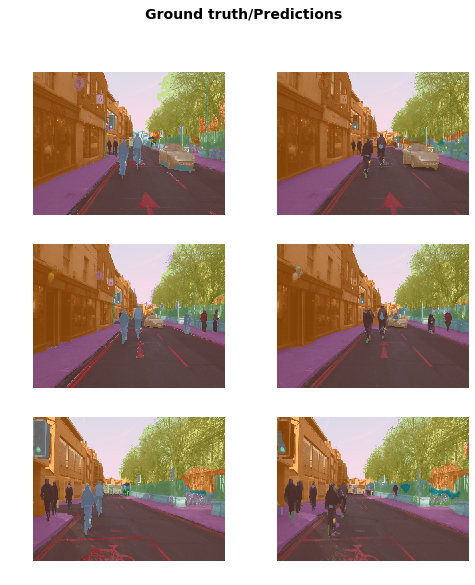

In [37]:
learn.show_results(rows=3, figsize=(8,9))

now we can unfreeze and train again.. And then we can increase pixel count and train again. Then again unfreeze it and train again. Can;t do today as it is really late and training all these will take quite a lot of time.. Maybe some other day